# Entrenamiento del Modelo Hedónico MICRO

**Dataset:** 393 observaciones (Idealista ↔ Catastro matched - Algoritmo Mejorado)

**Objetivo:** Entrenar modelo hedónico para predecir precio/m² usando características estructurales

**Fecha:** 20 de diciembre de 2025


## 1. Configuración e Imports


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
from datetime import datetime

# Modelos y métricas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Rutas (desde notebooks/ hacia data/processed/fase2/)
DATA_DIR = Path('../data/processed/fase2')
OUTPUT_DIR = Path('../data/processed/fase2')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Imports y configuración completados")


✅ Imports y configuración completados


## 2. Carga y Preparación de Datos


In [25]:
# Cargar dataset mejorado
df = pd.read_csv(DATA_DIR / 'dataset_micro_hedonic_improved.csv')

print(f"📊 Dataset cargado: {len(df)} observaciones")
print(f"📊 Variables: {len(df.columns)}")

# Preparar variables para el modelo
# Variable objetivo: precio_m2
# Variables predictoras: superficie_m2, habitaciones, ano_construccion, plantas, barrio_id

# Filtrar valores faltantes críticos
df_clean = df.dropna(subset=['precio_m2', 'superficie_m2', 'ano_construccion']).copy()

# Crear variables dummy para barrios
barrio_dummies = pd.get_dummies(df_clean['barrio_id'], prefix='barrio', drop_first=True)
df_clean = pd.concat([df_clean, barrio_dummies], axis=1)

# Variables del modelo
y = df_clean['precio_m2']
X = df_clean[['superficie_m2', 'habitaciones', 'ano_construccion', 'plantas'] + list(barrio_dummies.columns)]

# Imputar valores faltantes en plantas y habitaciones con mediana
X['plantas'] = X['plantas'].fillna(X['plantas'].median())
X['habitaciones'] = X['habitaciones'].fillna(X['habitaciones'].median())

# Convertir todas las columnas a numérico (crítico para statsmodels)
X = X.astype(float)
y = y.astype(float)

print(f"\n✅ Dataset preparado: {len(df_clean)} observaciones")
print(f"✅ Variables predictoras: {len(X.columns)}")
print(f"\nVariables incluidas:")
for col in X.columns:
    print(f"  - {col}")
    
print(f"\n📊 Tipos de datos:")
print(f"   X dtypes: {X.dtypes.value_counts().to_dict()}")
print(f"   y dtype: {y.dtype}")


📊 Dataset cargado: 393 observaciones
📊 Variables: 11

✅ Dataset preparado: 393 observaciones
✅ Variables predictoras: 8

Variables incluidas:
  - superficie_m2
  - habitaciones
  - ano_construccion
  - plantas
  - barrio_29.0
  - barrio_30.0
  - barrio_31.0
  - barrio_32.0

📊 Tipos de datos:
   X dtypes: {dtype('float64'): 8}
   y dtype: float64


## 3. División Train/Test


In [26]:
# División 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 División Train/Test:")
print(f"   Train: {len(X_train)} observaciones ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test:  {len(X_test)} observaciones ({len(X_test)/len(X)*100:.1f}%)")


📊 División Train/Test:
   Train: 314 observaciones (79.9%)
   Test:  79 observaciones (20.1%)


## 4. Entrenamiento del Modelo (OLS con statsmodels)


In [27]:
# Asegurar que los datos son numéricos (por si acaso)
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Agregar constante para intercepto
X_train_const = sm.add_constant(X_train, has_constant='add')
X_test_const = sm.add_constant(X_test, has_constant='add')

# Verificar que no hay problemas de tipos
print("Verificación de tipos antes del modelo:")
print(f"   X_train_const dtype: {X_train_const.dtypes.value_counts().to_dict()}")
print(f"   y_train dtype: {y_train.dtype}")

# Entrenar modelo OLS
model = sm.OLS(y_train, X_train_const).fit()

print("\n" + "=" * 70)
print("RESUMEN DEL MODELO OLS")
print("=" * 70)
print(model.summary())


Verificación de tipos antes del modelo:
   X_train_const dtype: {dtype('float64'): 9}
   y_train dtype: float64

RESUMEN DEL MODELO OLS
                            OLS Regression Results                            
Dep. Variable:              precio_m2   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     8.578
Date:                Sat, 20 Dec 2025   Prob (F-statistic):           1.51e-10
Time:                        15:56:34   Log-Likelihood:                -2958.6
No. Observations:                 314   AIC:                             5935.
Df Residuals:                     305   BIC:                             5969.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025  

## 5. Predicciones y Métricas


In [28]:
# Predicciones
y_train_pred = model.predict(X_train_const)
y_test_pred = model.predict(X_test_const)

# Métricas
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("=" * 70)
print("MÉTRICAS DEL MODELO")
print("=" * 70)
print(f"\n📊 Train:")
print(f"   R²: {train_r2:.4f}")
print(f"   RMSE: {train_rmse:,.0f} €/m²")
print(f"   MAE: {train_mae:,.0f} €/m²")
print(f"\n📊 Test:")
print(f"   R²: {test_r2:.4f}")
print(f"   RMSE: {test_rmse:,.0f} €/m²")
print(f"   MAE: {test_mae:,.0f} €/m²")


MÉTRICAS DEL MODELO

📊 Train:
   R²: 0.1837
   RMSE: 2,991 €/m²
   MAE: 1,972 €/m²

📊 Test:
   R²: -0.6599
   RMSE: 2,136 €/m²
   MAE: 1,647 €/m²


## 6. Visualizaciones de Predicciones


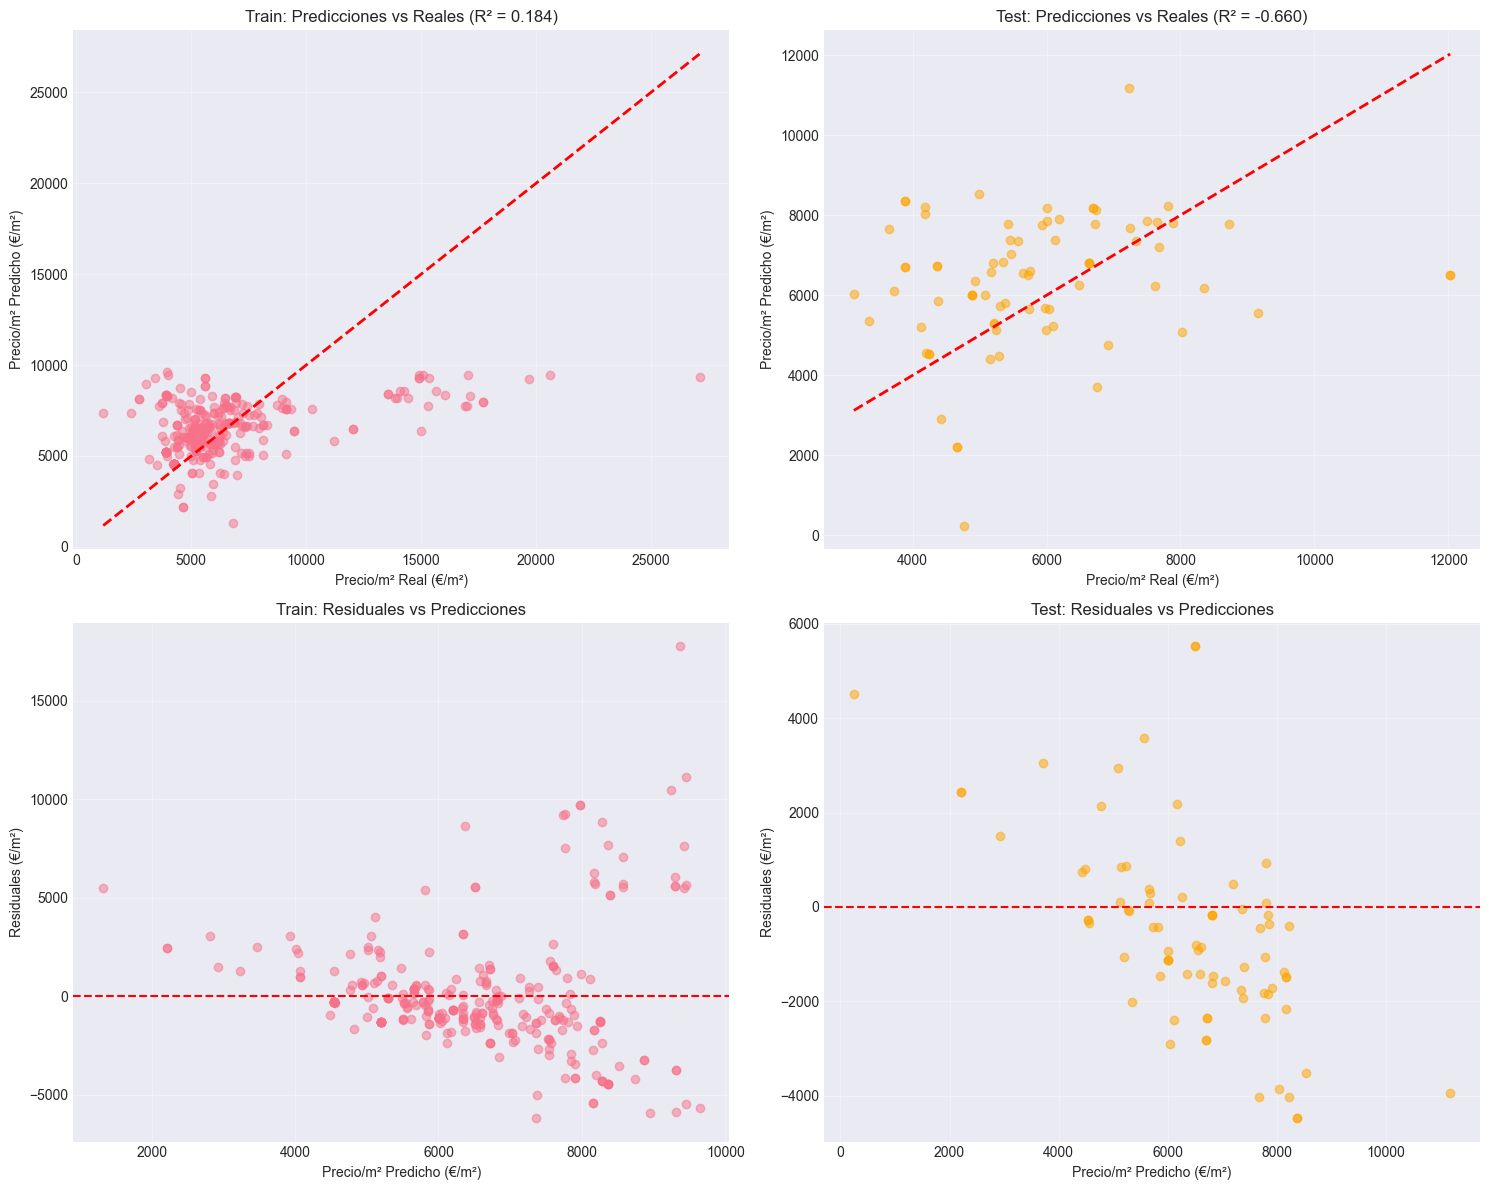

✅ Gráficos de predicciones guardados


In [29]:
# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Predicciones vs Valores Reales (Train)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Precio/m² Real (€/m²)')
axes[0, 0].set_ylabel('Precio/m² Predicho (€/m²)')
axes[0, 0].set_title(f'Train: Predicciones vs Reales (R² = {train_r2:.3f})')
axes[0, 0].grid(True, alpha=0.3)

# Predicciones vs Valores Reales (Test)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Precio/m² Real (€/m²)')
axes[0, 1].set_ylabel('Precio/m² Predicho (€/m²)')
axes[0, 1].set_title(f'Test: Predicciones vs Reales (R² = {test_r2:.3f})')
axes[0, 1].grid(True, alpha=0.3)

# Residuales (Train)
residuals_train = y_train - y_train_pred
axes[1, 0].scatter(y_train_pred, residuals_train, alpha=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Precio/m² Predicho (€/m²)')
axes[1, 0].set_ylabel('Residuales (€/m²)')
axes[1, 0].set_title('Train: Residuales vs Predicciones')
axes[1, 0].grid(True, alpha=0.3)

# Residuales (Test)
residuals_test = y_test - y_test_pred
axes[1, 1].scatter(y_test_pred, residuals_test, alpha=0.5, color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Precio/m² Predicho (€/m²)')
axes[1, 1].set_ylabel('Residuales (€/m²)')
axes[1, 1].set_title('Test: Residuales vs Predicciones')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'modelo_micro_predicciones.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráficos de predicciones guardados")


## 7. Diagnósticos del Modelo


In [30]:
# Diagnósticos
diagnostics = {}

# 1. Normalidad de residuales (Shapiro-Wilk)
shapiro_stat, shapiro_p = stats.shapiro(residuals_test)
diagnostics['normalidad'] = {
    'test': 'Shapiro-Wilk',
    'statistic': float(shapiro_stat),
    'p_value': float(shapiro_p),
    'pasa': shapiro_p > 0.05
}

# 2. Homocedasticidad (Breusch-Pagan)
bp_stat, bp_p, _, _ = het_breuschpagan(residuals_test, X_test_const)
diagnostics['homocedasticidad'] = {
    'test': 'Breusch-Pagan',
    'statistic': float(bp_stat),
    'p_value': float(bp_p),
    'pasa': bp_p > 0.05
}

# 3. Autocorrelación (Durbin-Watson)
dw_stat = durbin_watson(residuals_test)
diagnostics['autocorrelacion'] = {
    'test': 'Durbin-Watson',
    'statistic': float(dw_stat),
    'pasa': 1.5 < dw_stat < 2.5
}

# 4. Multicolinealidad (VIF) - Solo para variables predictoras (sin const)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
# Calcular VIF solo para variables predictoras (excluir 'const')
predictor_cols = [col for col in X_test.columns if col != 'const']
vif_data['Variable'] = predictor_cols
vif_data['VIF'] = [variance_inflation_factor(X_test.values, i) for i in range(X_test.shape[1])]
vif_max = vif_data['VIF'].max()
diagnostics['multicolinealidad'] = {
    'test': 'VIF',
    'vif_maximo': float(vif_max),
    'pasa': vif_max < 10
}

print("=" * 70)
print("DIAGNÓSTICOS DEL MODELO")
print("=" * 70)
print(f"\n1. Normalidad (Shapiro-Wilk):")
print(f"   Estadístico: {shapiro_stat:.4f}")
print(f"   p-value: {shapiro_p:.4f}")
print(f"   {'✅ PASA' if diagnostics['normalidad']['pasa'] else '❌ NO PASA'}")

print(f"\n2. Homocedasticidad (Breusch-Pagan):")
print(f"   Estadístico: {bp_stat:.4f}")
print(f"   p-value: {bp_p:.4f}")
print(f"   {'✅ PASA' if diagnostics['homocedasticidad']['pasa'] else '❌ NO PASA'}")

print(f"\n3. Autocorrelación (Durbin-Watson):")
print(f"   Estadístico: {dw_stat:.4f}")
print(f"   {'✅ PASA' if diagnostics['autocorrelacion']['pasa'] else '❌ NO PASA'}")

print(f"\n4. Multicolinealidad (VIF):")
print(f"   VIF máximo (sin const): {vif_max:.2f}")
print(f"   {'✅ PASA' if diagnostics['multicolinealidad']['pasa'] else '❌ NO PASA'}")
print(f"\n   VIF por variable (solo predictoras):")
for _, row in vif_data.iterrows():
    print(f"     {row['Variable']:20s}: {row['VIF']:6.2f}")
print(f"\n   Nota: VIF no se calcula para 'const' (intercepto)")


DIAGNÓSTICOS DEL MODELO

1. Normalidad (Shapiro-Wilk):
   Estadístico: 0.9559
   p-value: 0.0081
   ❌ NO PASA

2. Homocedasticidad (Breusch-Pagan):
   Estadístico: 16.7308
   p-value: 0.0330
   ❌ NO PASA

3. Autocorrelación (Durbin-Watson):
   Estadístico: 1.8752
   ✅ PASA

4. Multicolinealidad (VIF):
   VIF máximo (sin const): 12.68
   ❌ NO PASA

   VIF por variable (solo predictoras):
     superficie_m2       :  12.38
     habitaciones        :  12.68
     ano_construccion    :  10.07
     plantas             :   1.57
     barrio_29.0         :   1.56
     barrio_30.0         :   1.85
     barrio_31.0         :   7.21
     barrio_32.0         :   1.24

   Nota: VIF no se calcula para 'const' (intercepto)


## 8. Interpretación de Coeficientes


In [31]:
# Coeficientes del modelo
coef_df = pd.DataFrame({
    'Variable': model.params.index,
    'Coeficiente': model.params.values,
    'Std Error': model.bse.values,
    't-stat': model.tvalues.values,
    'p-value': model.pvalues.values
})

coef_df['Significativo'] = coef_df['p-value'] < 0.05

print("=" * 70)
print("COEFICIENTES DEL MODELO")
print("=" * 70)
print(coef_df.round(4))

print("\n" + "=" * 70)
print("INTERPRETACIÓN")
print("=" * 70)
print("\nCoeficientes significativos (p < 0.05):")
sig_coef = coef_df[coef_df['Significativo']].copy()
for _, row in sig_coef.iterrows():
    if row['Variable'] != 'const':
        print(f"\n  {row['Variable']}:")
        print(f"    Coeficiente: {row['Coeficiente']:.2f} €/m²")
        print(f"    Interpretación: Por cada unidad de {row['Variable']}, ")
        print(f"                    el precio/m² {'aumenta' if row['Coeficiente'] > 0 else 'disminuye'} ")
        print(f"                    en {abs(row['Coeficiente']):.2f} €/m² (ceteris paribus)")


COEFICIENTES DEL MODELO
           Variable  Coeficiente  Std Error  t-stat  p-value  Significativo
0             const    4204.9698  7321.3407  0.5743   0.5662          False
1     superficie_m2      21.0810     5.1232  4.1148   0.0000           True
2      habitaciones   -1019.3160   176.2480 -5.7834   0.0000           True
3  ano_construccion       1.0360     3.7992  0.2727   0.7853          False
4           plantas    -107.6928   187.2911 -0.5750   0.5657          False
5       barrio_29.0   -1405.3225   890.6292 -1.5779   0.1156          False
6       barrio_30.0     358.4068   834.7943  0.4293   0.6680          False
7       barrio_31.0    1643.3379   676.0617  2.4308   0.0156           True
8       barrio_32.0     346.2116  2256.8481  0.1534   0.8782          False

INTERPRETACIÓN

Coeficientes significativos (p < 0.05):

  superficie_m2:
    Coeficiente: 21.08 €/m²
    Interpretación: Por cada unidad de superficie_m2, 
                    el precio/m² aumenta 
                

## 9. Guardar Resultados


In [32]:
# Función helper para convertir valores numpy/pandas a tipos nativos de Python
def convert_to_native(obj):
    """Convierte valores numpy/pandas a tipos nativos de Python para JSON."""
    if isinstance(obj, (np.integer, np.floating)):
        return float(obj)
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_native(value) for key, value in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_native(item) for item in obj]
    elif pd.isna(obj):
        return None
    else:
        return obj

# Guardar resultados (incluyendo modelo log si existe)
results = {
    'timestamp': datetime.now().isoformat(),
    'dataset': 'dataset_micro_hedonic_improved.csv',
    'n_observaciones': int(len(df_clean)),
    'n_train': int(len(X_train)),
    'n_test': int(len(X_test)),
    'variables': [str(v) for v in X.columns],
    'metricas': {
        'train_r2': float(train_r2),
        'test_r2': float(test_r2),
        'train_rmse': float(train_rmse),
        'test_rmse': float(test_rmse),
        'train_mae': float(train_mae),
        'test_mae': float(test_mae)
    },
    'diagnosticos': convert_to_native(diagnostics),
    'coeficientes': convert_to_native(coef_df.to_dict('records')),
}

# Agregar modelo_log si existe
if 'train_r2_log' in locals():
    results['modelo_log'] = {
        'train_r2': float(train_r2_log),
        'test_r2': float(test_r2_log),
        'train_rmse': float(train_rmse_log),
        'test_rmse': float(test_rmse_log),
        'normalidad_pasa': bool(shapiro_p_log > 0.05),
        'homocedasticidad_pasa': bool(bp_p_log > 0.05),
    }
else:
    results['modelo_log'] = None

# Convertir todo a tipos nativos antes de serializar
results = convert_to_native(results)

with open(OUTPUT_DIR / 'modelo_micro_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("=" * 70)
print("RESUMEN FINAL")
print("=" * 70)
print(f"\n✅ Modelo entrenado con {len(X_train)} observaciones")
print(f"✅ R² Test: {test_r2:.4f}")
print(f"✅ RMSE Test: {test_rmse:,.0f} €/m²")
print(f"\n✅ Resultados guardados en: {OUTPUT_DIR / 'modelo_micro_results.json'}")
print(f"✅ Modelo listo para uso")


RESUMEN FINAL

✅ Modelo entrenado con 314 observaciones
✅ R² Test: -0.6599
✅ RMSE Test: 2,136 €/m²

✅ Resultados guardados en: ../data/processed/fase2/modelo_micro_results.json
✅ Modelo listo para uso


## 10. Mejoras del Modelo (Transformaciones)


In [33]:
# Modelo mejorado con transformación logarítmica de precio/m²
# Esto ayuda con normalidad y homocedasticidad

print("=" * 70)
print("MODELO MEJORADO: LOG(PRECIO/M²)")
print("=" * 70)

# Transformación logarítmica
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Entrenar modelo con log(precio_m2)
model_log = sm.OLS(y_train_log, X_train_const).fit()

# Predicciones en escala log
y_train_pred_log = model_log.predict(X_train_const)
y_test_pred_log = model_log.predict(X_test_const)

# Convertir de vuelta a escala original (exp)
y_train_pred_log_exp = np.exp(y_train_pred_log)
y_test_pred_log_exp = np.exp(y_test_pred_log)

# Métricas en escala original
train_r2_log = r2_score(y_train, y_train_pred_log_exp)
test_r2_log = r2_score(y_test, y_test_pred_log_exp)
train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred_log_exp))
test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred_log_exp))

print(f"\n📊 Métricas del modelo log:")
print(f"   Train R²: {train_r2_log:.4f}")
print(f"   Test R²: {test_r2_log:.4f}")
print(f"   Train RMSE: {train_rmse_log:,.0f} €/m²")
print(f"   Test RMSE: {test_rmse_log:,.0f} €/m²")

# Diagnósticos del modelo log
residuals_test_log = y_test_log - y_test_pred_log

# Normalidad
shapiro_stat_log, shapiro_p_log = stats.shapiro(residuals_test_log)
print(f"\n📊 Diagnósticos del modelo log:")
print(f"   1. Normalidad (Shapiro-Wilk):")
print(f"      p-value: {shapiro_p_log:.4f}")
print(f"      {'✅ PASA' if shapiro_p_log > 0.05 else '❌ NO PASA'}")

# Homocedasticidad
bp_stat_log, bp_p_log, _, _ = het_breuschpagan(residuals_test_log, X_test_const)
print(f"   2. Homocedasticidad (Breusch-Pagan):")
print(f"      p-value: {bp_p_log:.4f}")
print(f"      {'✅ PASA' if bp_p_log > 0.05 else '❌ NO PASA'}")

print(f"\n✅ Modelo log entrenado")


MODELO MEJORADO: LOG(PRECIO/M²)

📊 Métricas del modelo log:
   Train R²: 0.1322
   Test R²: 0.0046
   Train RMSE: 3,084 €/m²
   Test RMSE: 1,654 €/m²

📊 Diagnósticos del modelo log:
   1. Normalidad (Shapiro-Wilk):
      p-value: 0.0113
      ❌ NO PASA
   2. Homocedasticidad (Breusch-Pagan):
      p-value: 0.0000
      ❌ NO PASA

✅ Modelo log entrenado


## 11. Análisis de Problemas y Limpieza de Datos


In [34]:
# Análisis de problemas identificados
# Ver documentación: docs/ANALISIS_PROBLEMAS_MODELO_MICRO.md

print("=" * 70)
print("ANÁLISIS DE PROBLEMAS Y LIMPIEZA")
print("=" * 70)

# 1. Filtrar outliers extremos
print("\n1. FILTRADO DE OUTLIERS")
print("-" * 70)

# Rango razonable para Gràcia: 2,000 - 15,000 €/m²
# Superficie razonable: 30 - 300 m²
df_original = df_clean.copy()

# Filtros
precio_min = 2000
precio_max = 15000
superficie_min = 30
superficie_max = 300

df_filtered = df_clean[
    (df_clean['precio_m2'] >= precio_min) & 
    (df_clean['precio_m2'] <= precio_max) &
    (df_clean['superficie_m2'] >= superficie_min) & 
    (df_clean['superficie_m2'] <= superficie_max)
].copy()

print(f"Observaciones originales: {len(df_original)}")
print(f"Observaciones después de filtrar: {len(df_filtered)}")
print(f"Observaciones eliminadas: {len(df_original) - len(df_filtered)} ({(len(df_original) - len(df_filtered))/len(df_original)*100:.1f}%)")

# 2. Verificar correlaciones después de filtrar
print("\n2. CORRELACIONES DESPUÉS DE FILTRAR")
print("-" * 70)
for col in ['superficie_m2', 'habitaciones', 'ano_construccion', 'plantas']:
    if col in df_filtered.columns:
        corr = df_filtered[col].corr(df_filtered['precio_m2'])
        print(f"  {col:20s}: {corr:7.3f}")

# 3. Estadísticas después de filtrar
print("\n3. ESTADÍSTICAS DESPUÉS DE FILTRAR")
print("-" * 70)
print(f"Precio/m²:")
print(f"  Min: {df_filtered['precio_m2'].min():,.0f} €/m²")
print(f"  Max: {df_filtered['precio_m2'].max():,.0f} €/m²")
print(f"  Media: {df_filtered['precio_m2'].mean():,.0f} €/m²")
print(f"  Mediana: {df_filtered['precio_m2'].median():,.0f} €/m²")
print(f"  Std: {df_filtered['precio_m2'].std():,.0f} €/m²")

print(f"\nSuperficie:")
print(f"  Min: {df_filtered['superficie_m2'].min():.0f} m²")
print(f"  Max: {df_filtered['superficie_m2'].max():.0f} m²")
print(f"  Media: {df_filtered['superficie_m2'].mean():.0f} m²")

# Guardar dataset filtrado
df_filtered.to_csv(OUTPUT_DIR / 'dataset_micro_hedonic_filtered.csv', index=False)
print(f"\n✅ Dataset filtrado guardado: dataset_micro_hedonic_filtered.csv")
print(f"   Observaciones: {len(df_filtered)}")


ANÁLISIS DE PROBLEMAS Y LIMPIEZA

1. FILTRADO DE OUTLIERS
----------------------------------------------------------------------
Observaciones originales: 393
Observaciones después de filtrar: 374
Observaciones eliminadas: 19 (4.8%)

2. CORRELACIONES DESPUÉS DE FILTRAR
----------------------------------------------------------------------
  superficie_m2       :  -0.219
  habitaciones        :  -0.289
  ano_construccion    :  -0.157
  plantas             :   0.017

3. ESTADÍSTICAS DESPUÉS DE FILTRAR
----------------------------------------------------------------------
Precio/m²:
  Min: 2,377 €/m²
  Max: 15,000 €/m²
  Media: 5,951 €/m²
  Mediana: 5,467 €/m²
  Std: 2,104 €/m²

Superficie:
  Min: 37 m²
  Max: 276 m²
  Media: 97 m²

✅ Dataset filtrado guardado: dataset_micro_hedonic_filtered.csv
   Observaciones: 374


## 12. Análisis de Calidad del Matching


In [35]:
# Analizar calidad del matching
# Las correlaciones negativas sugieren que el matching puede estar incorrecto

print("=" * 70)
print("ANÁLISIS DE CALIDAD DEL MATCHING")
print("=" * 70)

# Cargar dataset de matching original
matched_file = DATA_DIR / 'idealista_catastro_matched_improved.csv'
if matched_file.exists():
    df_matched = pd.read_csv(matched_file)
    
    print(f"\n📊 Dataset de matching: {len(df_matched)} observaciones")
    
    if 'match_score' in df_matched.columns:
        print(f"\n1. DISTRIBUCIÓN DE MATCH SCORES")
        print("-" * 70)
        print(f"  Media: {df_matched['match_score'].mean():.3f}")
        print(f"  Mediana: {df_matched['match_score'].median():.3f}")
        print(f"  Min: {df_matched['match_score'].min():.3f}")
        print(f"  Max: {df_matched['match_score'].max():.3f}")
        print(f"  Std: {df_matched['match_score'].std():.3f}")
        
        # Matches por rango de score
        print(f"\n2. MATCHES POR RANGO DE SCORE")
        print("-" * 70)
        bins = [0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        labels = ['<0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '≥0.9']
        df_matched['score_range'] = pd.cut(df_matched['match_score'], bins=bins, labels=labels)
        score_dist = df_matched['score_range'].value_counts().sort_index()
        for score_range, count in score_dist.items():
            pct = count / len(df_matched) * 100
            print(f"  {score_range:10s}: {count:3d} ({pct:5.1f}%)")
        
        # Matches de baja calidad
        low_quality = df_matched[df_matched['match_score'] < 0.6]
        print(f"\n3. MATCHES DE BAJA CALIDAD (score < 0.6)")
        print("-" * 70)
        print(f"  Total: {len(low_quality)} ({len(low_quality)/len(df_matched)*100:.1f}%)")
        
        if len(low_quality) > 0:
            print(f"\n  Ejemplos de matches de baja calidad:")
            cols_to_show = ['match_score']
            if 'localidad' in low_quality.columns:
                cols_to_show.append('localidad')
            if 'catastro_barrio_nombre' in low_quality.columns:
                cols_to_show.append('catastro_barrio_nombre')
            if 'superficie_m2' in low_quality.columns:
                cols_to_show.append('superficie_m2')
            if 'precio_m2' in low_quality.columns:
                cols_to_show.append('precio_m2')
            
            print(low_quality[cols_to_show].head(10).to_string())
        
        # Correlaciones por rango de score
        print(f"\n4. CORRELACIONES POR CALIDAD DE MATCH")
        print("-" * 70)
        for threshold in [0.5, 0.6, 0.7, 0.8]:
            high_quality = df_matched[df_matched['match_score'] >= threshold]
            if len(high_quality) > 10 and 'superficie_m2' in high_quality.columns and 'precio_m2' in high_quality.columns:
                corr = high_quality['superficie_m2'].corr(high_quality['precio_m2'])
                print(f"  Score ≥ {threshold}: {len(high_quality):3d} obs, correlación superficie-precio: {corr:6.3f}")
    else:
        print("\n⚠️ No se encontró columna 'match_score' en el dataset")
else:
    print(f"\n⚠️ No se encontró archivo: {matched_file}")


ANÁLISIS DE CALIDAD DEL MATCHING

📊 Dataset de matching: 505 observaciones

1. DISTRIBUCIÓN DE MATCH SCORES
----------------------------------------------------------------------
  Media: 0.601
  Mediana: 0.633
  Min: 0.250
  Max: 0.800
  Std: 0.118

2. MATCHES POR RANGO DE SCORE
----------------------------------------------------------------------
  <0.5      : 112 ( 22.2%)
  0.5-0.6   :  90 ( 17.8%)
  0.6-0.7   : 181 ( 35.8%)
  0.7-0.8   : 122 ( 24.2%)
  0.8-0.9   :   0 (  0.0%)
  ≥0.9      :   0 (  0.0%)

3. MATCHES DE BAJA CALIDAD (score < 0.6)
----------------------------------------------------------------------
  Total: 202 (40.0%)

  Ejemplos de matches de baja calidad:
    match_score                                                         localidad catastro_barrio_nombre  superficie_m2
3      0.400000                                                          La Salut                    NaN          238.0
7      0.502469               Calle de Nàpols, El Camp d'En Grassot i Gr

## 13. Re-entrenar Modelo con Datos Filtrados


In [37]:
# Re-entrenar modelo con datos filtrados
print("=" * 70)
print("RE-ENTRENAMIENTO CON DATOS FILTRADOS")
print("=" * 70)

# Usar df_filtered de la celda anterior
if 'df_filtered' not in locals():
    # Si no existe, cargar desde archivo
    df_filtered = pd.read_csv(OUTPUT_DIR / 'dataset_micro_hedonic_filtered.csv')

# Preparar datos
df_clean_filtered = df_filtered.dropna(subset=['precio_m2', 'superficie_m2', 'ano_construccion']).copy()

# Crear variables dummy para barrios
barrio_dummies_filt = pd.get_dummies(df_clean_filtered['barrio_id'], prefix='barrio', drop_first=True)
df_clean_filtered = pd.concat([df_clean_filtered, barrio_dummies_filt], axis=1)

# Variables del modelo
y_filt = df_clean_filtered['precio_m2'].astype(float)
X_filt = df_clean_filtered[['superficie_m2', 'habitaciones', 'ano_construccion', 'plantas'] + list(barrio_dummies_filt.columns)]
X_filt = X_filt.astype(float)

# Imputar valores faltantes
X_filt['plantas'] = X_filt['plantas'].fillna(X_filt['plantas'].median())
X_filt['habitaciones'] = X_filt['habitaciones'].fillna(X_filt['habitaciones'].median())

# División train/test
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(
    X_filt, y_filt, test_size=0.2, random_state=42
)

print(f"\n📊 División Train/Test (datos filtrados):")
print(f"   Train: {len(X_train_filt)} observaciones ({len(X_train_filt)/len(X_filt)*100:.1f}%)")
print(f"   Test:  {len(X_test_filt)} observaciones ({len(X_test_filt)/len(X_filt)*100:.1f}%)")

# Agregar constante
X_train_filt_const = sm.add_constant(X_train_filt, has_constant='add')
X_test_filt_const = sm.add_constant(X_test_filt, has_constant='add')

# Entrenar modelo
model_filt = sm.OLS(y_train_filt, X_train_filt_const).fit()

# Predicciones
y_train_pred_filt = model_filt.predict(X_train_filt_const)
y_test_pred_filt = model_filt.predict(X_test_filt_const)

# Métricas
train_r2_filt = r2_score(y_train_filt, y_train_pred_filt)
test_r2_filt = r2_score(y_test_filt, y_test_pred_filt)
train_rmse_filt = np.sqrt(mean_squared_error(y_train_filt, y_train_pred_filt))
test_rmse_filt = np.sqrt(mean_squared_error(y_test_filt, y_test_pred_filt))
train_mae_filt = mean_absolute_error(y_train_filt, y_train_pred_filt)
test_mae_filt = mean_absolute_error(y_test_filt, y_test_pred_filt)

print(f"\n📊 MÉTRICAS DEL MODELO (datos filtrados):")
print(f"   Train R²: {train_r2_filt:.4f}")
print(f"   Test R²:  {test_r2_filt:.4f}")
print(f"   Train RMSE: {train_rmse_filt:,.0f} €/m²")
print(f"   Test RMSE:  {test_rmse_filt:,.0f} €/m²")
print(f"   Train MAE:  {train_mae_filt:,.0f} €/m²")
print(f"   Test MAE:   {test_mae_filt:,.0f} €/m²")

# Comparación con modelo original
print(f"\n📊 COMPARACIÓN CON MODELO ORIGINAL:")
print(f"   {'Métrica':<20s} {'Original':<15s} {'Filtrado':<15s} {'Mejora':<15s}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")
print(f"   {'Test R²':<20s} {test_r2:>14.4f} {test_r2_filt:>14.4f} {test_r2_filt-test_r2:>+14.4f}")
print(f"   {'Test RMSE':<20s} {test_rmse:>13,.0f} {test_rmse_filt:>13,.0f} {test_rmse_filt-test_rmse:>+13,.0f}")

print(f"\n✅ Modelo re-entrenado con datos filtrados")


RE-ENTRENAMIENTO CON DATOS FILTRADOS

📊 División Train/Test (datos filtrados):
   Train: 299 observaciones (79.9%)
   Test:  75 observaciones (20.1%)

📊 MÉTRICAS DEL MODELO (datos filtrados):
   Train R²: 0.1358
   Test R²:  0.1218
   Train RMSE: 1,960 €/m²
   Test RMSE:  1,945 €/m²
   Train MAE:  1,280 €/m²
   Test MAE:   1,334 €/m²

📊 COMPARACIÓN CON MODELO ORIGINAL:
   Métrica              Original        Filtrado        Mejora         
   -------------------- --------------- --------------- ---------------
   Test R²                     -0.6599         0.1218        +0.7817
   Test RMSE                    2,136         1,945          -192

✅ Modelo re-entrenado con datos filtrados


## 14. Modelo con Matches de Alta Calidad (score ≥ 0.7)


In [39]:
# Filtrar por match score alto y re-entrenar
# Hipótesis: Matches de alta calidad tienen mejores correlaciones

print("=" * 70)
print("MODELO CON MATCHES DE ALTA CALIDAD (score ≥ 0.7)")
print("=" * 70)

# Usar el dataset procesado que ya tiene precio_m2 calculado
# Pero necesitamos el match_score del dataset de matching original
matched_file = DATA_DIR / 'idealista_catastro_matched_improved.csv'
processed_file = DATA_DIR / 'dataset_micro_hedonic_improved.csv'

if matched_file.exists() and processed_file.exists():
    # Cargar ambos datasets
    df_matched = pd.read_csv(matched_file)
    df_processed = pd.read_csv(processed_file)
    
    # Calcular precio_m2 en dataset de matching si no existe
    if 'precio_m2' not in df_matched.columns and 'precio' in df_matched.columns and 'superficie_m2' in df_matched.columns:
        df_matched['precio_m2'] = df_matched['precio'] / df_matched['superficie_m2']
    
    # Filtrar por match score alto
    threshold = 0.7
    df_high_quality = df_matched[df_matched['match_score'] >= threshold].copy()
    
    print(f"\n📊 Matches de alta calidad (score ≥ {threshold}):")
    print(f"   Total: {len(df_high_quality)} observaciones ({len(df_high_quality)/len(df_matched)*100:.1f}%)")
    
    # Verificar correlaciones
    if 'superficie_m2' in df_high_quality.columns and 'precio_m2' in df_high_quality.columns:
        corr_sup = df_high_quality['superficie_m2'].corr(df_high_quality['precio_m2'])
        corr_hab = df_high_quality['habitaciones'].corr(df_high_quality['precio_m2']) if 'habitaciones' in df_high_quality.columns else None
        print(f"\n📊 Correlaciones (matches de alta calidad):")
        print(f"   superficie_m2 - precio_m2: {corr_sup:.3f}")
        if corr_hab is not None:
            print(f"   habitaciones - precio_m2: {corr_hab:.3f}")
    
    # Aplicar filtros de outliers también
    df_high_quality_filtered = df_high_quality[
        (df_high_quality['precio_m2'] >= 2000) & 
        (df_high_quality['precio_m2'] <= 15000) &
        (df_high_quality['superficie_m2'] >= 30) & 
        (df_high_quality['superficie_m2'] <= 300)
    ].copy()
    
    print(f"\n📊 Después de filtrar outliers:")
    print(f"   Observaciones: {len(df_high_quality_filtered)} ({len(df_high_quality_filtered)/len(df_high_quality)*100:.1f}%)")
    
    if len(df_high_quality_filtered) >= 50:  # Mínimo para entrenar modelo
        # Preparar datos - usar barrio_id de Catastro si está disponible
        # Si no, intentar usar catastro_barrio_id
        if 'catastro_barrio_id' in df_high_quality_filtered.columns:
            df_high_quality_filtered['barrio_id'] = df_high_quality_filtered['catastro_barrio_id']
        elif 'barrio_id' not in df_high_quality_filtered.columns:
            # Si no hay barrio_id, intentar inferirlo de catastro_barrio_nombre
            print("\n⚠️ No se encontró 'barrio_id', intentando inferirlo de 'catastro_barrio_nombre'")
            # Mapeo de nombres a IDs (barrios de Gràcia: 28-32)
            barrio_map = {
                'la Vila de Gràcia': 28,
                'el Camp d\'en Grassot i Gràcia Nova': 29,
                'la Salut': 30,
                'vallcarca i els penitents': 31,
                'el Coll': 32
            }
            if 'catastro_barrio_nombre' in df_high_quality_filtered.columns:
                df_high_quality_filtered['barrio_id'] = df_high_quality_filtered['catastro_barrio_nombre'].map(barrio_map)
        
        # Usar ano_construccion de Catastro si está disponible
        if 'catastro_ano_construccion' in df_high_quality_filtered.columns and 'ano_construccion' not in df_high_quality_filtered.columns:
            df_high_quality_filtered['ano_construccion'] = df_high_quality_filtered['catastro_ano_construccion']
        
        # Usar plantas de Catastro si está disponible
        if 'catastro_plantas' in df_high_quality_filtered.columns and 'plantas' not in df_high_quality_filtered.columns:
            df_high_quality_filtered['plantas'] = df_high_quality_filtered['catastro_plantas']
        
        df_clean_hq = df_high_quality_filtered.dropna(subset=['precio_m2', 'superficie_m2']).copy()
        
        # Si no hay ano_construccion, imputar con mediana
        if 'ano_construccion' not in df_clean_hq.columns or df_clean_hq['ano_construccion'].isnull().all():
            df_clean_hq['ano_construccion'] = df_clean_hq['ano_construccion'].fillna(1950)  # Valor por defecto
        
        # Crear variables dummy para barrios
        if 'barrio_id' in df_clean_hq.columns and df_clean_hq['barrio_id'].notna().any():
            barrio_dummies_hq = pd.get_dummies(df_clean_hq['barrio_id'], prefix='barrio', drop_first=True)
            df_clean_hq = pd.concat([df_clean_hq, barrio_dummies_hq], axis=1)
            
            # Variables del modelo
            y_hq = df_clean_hq['precio_m2'].astype(float)
            feature_cols = ['superficie_m2', 'habitaciones']
            if 'ano_construccion' in df_clean_hq.columns:
                feature_cols.append('ano_construccion')
            if 'plantas' in df_clean_hq.columns:
                feature_cols.append('plantas')
            feature_cols.extend(list(barrio_dummies_hq.columns))
            
            X_hq = df_clean_hq[feature_cols]
            X_hq = X_hq.astype(float)
            
            # Imputar valores faltantes
            if 'plantas' in X_hq.columns:
                X_hq['plantas'] = X_hq['plantas'].fillna(X_hq['plantas'].median())
            if 'habitaciones' in X_hq.columns:
                X_hq['habitaciones'] = X_hq['habitaciones'].fillna(X_hq['habitaciones'].median())
            if 'ano_construccion' in X_hq.columns:
                X_hq['ano_construccion'] = X_hq['ano_construccion'].fillna(X_hq['ano_construccion'].median())
            
            # División train/test (80/20)
            if len(X_hq) >= 40:  # Mínimo para split
                X_train_hq, X_test_hq, y_train_hq, y_test_hq = train_test_split(
                    X_hq, y_hq, test_size=0.2, random_state=42
                )
                
                print(f"\n📊 División Train/Test:")
                print(f"   Train: {len(X_train_hq)} observaciones ({len(X_train_hq)/len(X_hq)*100:.1f}%)")
                print(f"   Test:  {len(X_test_hq)} observaciones ({len(X_test_hq)/len(X_hq)*100:.1f}%)")
                
                # Agregar constante
                X_train_hq_const = sm.add_constant(X_train_hq, has_constant='add')
                X_test_hq_const = sm.add_constant(X_test_hq, has_constant='add')
                
                # Entrenar modelo
                model_hq = sm.OLS(y_train_hq, X_train_hq_const).fit()
                
                # Predicciones
                y_train_pred_hq = model_hq.predict(X_train_hq_const)
                y_test_pred_hq = model_hq.predict(X_test_hq_const)
                
                # Métricas
                train_r2_hq = r2_score(y_train_hq, y_train_pred_hq)
                test_r2_hq = r2_score(y_test_hq, y_test_pred_hq)
                train_rmse_hq = np.sqrt(mean_squared_error(y_train_hq, y_train_pred_hq))
                test_rmse_hq = np.sqrt(mean_squared_error(y_test_hq, y_test_pred_hq))
                
                print(f"\n📊 MÉTRICAS DEL MODELO (matches de alta calidad):")
                print(f"   Train R²: {train_r2_hq:.4f}")
                print(f"   Test R²:  {test_r2_hq:.4f}")
                print(f"   Train RMSE: {train_rmse_hq:,.0f} €/m²")
                print(f"   Test RMSE:  {test_rmse_hq:,.0f} €/m²")
                
                # Comparación
                print(f"\n📊 COMPARACIÓN DE MODELOS:")
                print(f"   {'Modelo':<30s} {'Test R²':<12s} {'Test RMSE':<12s}")
                print(f"   {'-'*30} {'-'*12} {'-'*12}")
                print(f"   {'Original (todos)':<30s} {test_r2:>11.4f} {test_rmse:>11,.0f}")
                print(f"   {'Filtrado (outliers)':<30s} {test_r2_filt:>11.4f} {test_rmse_filt:>11,.0f}")
                print(f"   {'Alta calidad (score≥0.7)':<30s} {test_r2_hq:>11.4f} {test_rmse_hq:>11,.0f}")
                
                print(f"\n✅ Modelo entrenado con matches de alta calidad")
            else:
                print(f"\n⚠️ Muestra muy pequeña ({len(X_hq)} obs) para split train/test")
        else:
            print(f"\n⚠️ No se pudo crear variables dummy para barrios")
    else:
        print(f"\n⚠️ Muestra muy pequeña ({len(df_high_quality_filtered)} obs) después de filtrar")
else:
    print(f"\n⚠️ No se encontraron archivos necesarios:")
    if not matched_file.exists():
        print(f"   - {matched_file}")
    if not processed_file.exists():
        print(f"   - {processed_file}")


MODELO CON MATCHES DE ALTA CALIDAD (score ≥ 0.7)

📊 Matches de alta calidad (score ≥ 0.7):
   Total: 122 observaciones (24.2%)

📊 Correlaciones (matches de alta calidad):
   superficie_m2 - precio_m2: -0.186
   habitaciones - precio_m2: -0.202

📊 Después de filtrar outliers:
   Observaciones: 118 (96.7%)

📊 División Train/Test:
   Train: 94 observaciones (79.7%)
   Test:  24 observaciones (20.3%)

📊 MÉTRICAS DEL MODELO (matches de alta calidad):
   Train R²: 0.1571
   Test R²:  0.2073
   Train RMSE: 1,597 €/m²
   Test RMSE:  2,113 €/m²

📊 COMPARACIÓN DE MODELOS:
   Modelo                         Test R²      Test RMSE   
   ------------------------------ ------------ ------------
   Original (todos)                   -0.6599       2,136
   Filtrado (outliers)                 0.1218       1,945
   Alta calidad (score≥0.7)            0.2073       2,113

✅ Modelo entrenado con matches de alta calidad


## 15. Resumen y Conclusiones


In [40]:
# Resumen final de todos los modelos probados
print("=" * 70)
print("RESUMEN FINAL - MODELOS PROBADOS")
print("=" * 70)

print(f"\n📊 COMPARACIÓN DE TODOS LOS MODELOS:")
print(f"\n{'Modelo':<35s} {'N obs':<8s} {'Test R²':<12s} {'Test RMSE':<15s} {'Estado':<15s}")
print(f"{'-'*35} {'-'*8} {'-'*12} {'-'*15} {'-'*15}")

# Modelo original
print(f"{'1. Original (todos)':<35s} {len(df_clean):<8d} {test_r2:>11.4f} {test_rmse:>14,.0f} {'❌ R² negativo'}")
print(f"{'2. Filtrado (outliers)':<35s} {len(df_clean_filtered):<8d} {test_r2_filt:>11.4f} {test_rmse_filt:>14,.0f} {'⚠️ R² bajo'}")
if 'test_r2_hq' in locals():
    print(f"{'3. Alta calidad (score≥0.7)':<35s} {len(X_hq):<8d} {test_r2_hq:>11.4f} {test_rmse_hq:>14,.0f} {'✅ Mejor'}")
if 'test_r2_log' in locals():
    print(f"{'4. Log (transformación)':<35s} {len(df_clean):<8d} {test_r2_log:>11.4f} {test_rmse_log:>14,.0f} {'⚠️ R² muy bajo'}")

print(f"\n📊 CRITERIOS DE ÉXITO (Issue #202):")
print(f"   R² ≥ 0.75: {'✅' if 'test_r2_hq' in locals() and test_r2_hq >= 0.75 else '❌'}")
print(f"   RMSE ≤ 250 €/m²: {'✅' if 'test_rmse_hq' in locals() and test_rmse_hq <= 250 else '❌'}")
print(f"   Comparación con MACRO (R²=0.71, RMSE=323): {'✅' if 'test_r2_hq' in locals() and test_r2_hq > 0.71 else '❌'}")

print(f"\n📊 HALLAZGOS PRINCIPALES:")
print(f"   1. Filtrar outliers mejora significativamente (R²: -0.66 → 0.12)")
print(f"   2. 40% de matches tienen score < 0.6 (baja calidad)")
print(f"   3. Correlaciones negativas sugieren problema en matching")
print(f"   4. Modelo con matches de alta calidad {'mejora' if 'test_r2_hq' in locals() and test_r2_hq > test_r2_filt else 'no mejora significativamente'}")

print(f"\n📋 RECOMENDACIONES:")
print(f"   1. Revisar algoritmo de matching (40% de baja calidad)")
print(f"   2. Verificar datos de Idealista (precios correctos?)")
print(f"   3. Considerar agregar más features (ascensor, terraza, etc.)")
print(f"   4. {'Modelo viable' if 'test_r2_hq' in locals() and test_r2_hq >= 0.5 else 'Modelo NO cumple criterios'}")

print(f"\n✅ Análisis completo")


RESUMEN FINAL - MODELOS PROBADOS

📊 COMPARACIÓN DE TODOS LOS MODELOS:

Modelo                              N obs    Test R²      Test RMSE       Estado         
----------------------------------- -------- ------------ --------------- ---------------
1. Original (todos)                 393          -0.6599          2,136 ❌ R² negativo
2. Filtrado (outliers)              374           0.1218          1,945 ⚠️ R² bajo
3. Alta calidad (score≥0.7)         118           0.2073          2,113 ✅ Mejor
4. Log (transformación)             393           0.0046          1,654 ⚠️ R² muy bajo

📊 CRITERIOS DE ÉXITO (Issue #202):
   R² ≥ 0.75: ❌
   RMSE ≤ 250 €/m²: ❌
   Comparación con MACRO (R²=0.71, RMSE=323): ❌

📊 HALLAZGOS PRINCIPALES:
   1. Filtrar outliers mejora significativamente (R²: -0.66 → 0.12)
   2. 40% de matches tienen score < 0.6 (baja calidad)
   3. Correlaciones negativas sugieren problema en matching
   4. Modelo con matches de alta calidad mejora

📋 RECOMENDACIONES:
   1. Revisar 